In [1]:
import os

import cv2
import pandas as pd
import numpy as np
import tensorflow as tf
# import tensorflow_io as tfio
from tensorflow.keras import layers
from tensorflow import keras
import matplotlib.pyplot as plt
# from PIL import Image, ImageFilter, ImageEnhance
import random

print(tf.__version__)

2.6.2


In [2]:
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Default GPU Device: /device:GPU:0


2022-01-31 15:23:48.429157: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-31 15:23:48.473435: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-31 15:23:48.534412: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-31 15:23:48.534714: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so retur

In [3]:
maskDir = "Human-Segmentation-Dataset-master/Ground_Truth/"
samplesDir = "Human-Segmentation-Dataset-master/Training_Images/"

IMG_HEIGHT = 176
IMG_WIDTH = IMG_HEIGHT
CROP_WIDTH = 128
cropOffset = (IMG_WIDTH - CROP_WIDTH) // 2

[ WARN:0@31.866] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('Human-Segmentation-Dataset-master/Ground_Truth/Jazz_Jazz5_C1_00270.png'): can't open/read file: check file path/integrity


TypeError: Image data of dtype object cannot be converted to float

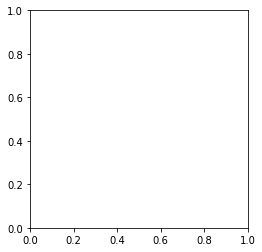

In [4]:
path = maskDir + "Jazz_Jazz5_C1_00270.png"#1803151818-00000010  Jazz_Jazz5_C1_00270
# If we don't use cv2.IMREAD_UNCHANGED then the image will be read with only 3 channels.
rgba_image = cv2.imread(path, cv2.IMREAD_UNCHANGED) 
plt.imshow(rgba_image)
plt.show()
w1, h1 = rgba_image.shape[:2]

perspSize = 40
pts1 = np.float32([[0, 0], [0, w1],
                   [h1, 0], [h1, w1]])
pts2 = np.float32([[random.randint(0,perspSize), random.randint(0,perspSize)], 
                   [random.randint(0,perspSize), random.randint(w1-perspSize,w1)],
                   [random.randint(h1-perspSize,h1), random.randint(0,perspSize)], 
                   [random.randint(h1-perspSize,h1), random.randint(w1-perspSize,w1)]])

# Apply Perspective Transform Algorithm
perspMatrix = cv2.getPerspectiveTransform(pts1, pts2)
rgba_image = cv2.warpPerspective(rgba_image, perspMatrix, (500, 600))
plt.imshow(rgba_image)
plt.show()


center = (w1/2, h1/2)
rotMatrix = cv2.getRotationMatrix2D(center, random.randint(-20,20), 1)
rgba_image = cv2.warpAffine(rgba_image, rotMatrix, (w1, h1))
cv2.warpPerspective
wScale = w1//IMG_WIDTH
hScale = h1//IMG_HEIGHT
newScale = min(wScale,hScale)
wOffset = (w1-(newScale*IMG_WIDTH))//2
hOffset = (h1-(newScale*IMG_WIDTH))//2

rgba_image = rgba_image[wOffset:w1-wOffset,hOffset:h1-hOffset,:]

rgba_image = cv2.resize(rgba_image, (IMG_HEIGHT, IMG_WIDTH))

rgba_image = rgba_image[:,cropOffset:IMG_WIDTH-cropOffset,:]

print((rgba_image.shape))
# select the 4th channel
# rgba_image = np.reshape(rgba_image, (rgba_image.shape[0], rgba_image.shape[1], 1))
alpha = rgba_image[:,:,2]



plt.imshow(alpha)

plt.show()

In [5]:
## keras.utils.load_img and plt.imread don't load the alpha channel if one exists

path = maskDir + "8.png" #maskDir samplesDir

matt = cv2.imread(path)#tf.keras.utils.load_img(path)#plt.imread(path)

mattarr = tf.keras.utils.img_to_array(matt)

alphaarr = mattarr[:,:,0]
print(matt.shape)
# print(alphaarr[np.argmax(alphaarr)])
# print(mattarr)

matt2 = plt.imread(path)#tf.keras.utils.img_to_array(matt)

print(matt2.shape)
# print(alphaarr)

plt.imshow(matt[:,:,0])

plt.show()

[ WARN:0@68.893] global /io/opencv/modules/imgcodecs/src/loadsave.cpp (239) findDecoder imread_('Human-Segmentation-Dataset-master/Ground_Truth/8.png'): can't open/read file: check file path/integrity


ValueError: Unsupported image shape: ()

## Generate the data files

In [4]:
# Create two pd dataframes to hold the names of the images.
main_folder = "/home/rimogardino/Downloads/ML/Human deleter/selfie segmentation data/"
samples = "clip_img/"
masks = "matting/"

df_img = pd.DataFrame([], columns=['image_id'])

df_img["img_folder_id"] = ""

df_mask = pd.DataFrame([], columns=['mask_id'])

df_mask["mask_folder_id"] = ""


for folder in os.listdir(main_folder+samples):
    for img_folder, mask_folder in zip(os.listdir(main_folder+samples+folder),os.listdir(main_folder+masks+folder)):
        img_folder = main_folder+samples+folder+"/"+img_folder
        mask_folder = main_folder+masks+folder+"/"+mask_folder

        image_list = os.listdir(img_folder)

        mask_list = os.listdir(mask_folder)

        df_img_1 = pd.DataFrame(image_list, columns=['image_id'])

        df_img_1["img_folder_id"] = img_folder + "/" 

        df_mask_1 = pd.DataFrame(mask_list, columns=['mask_id'])

        df_mask_1["mask_folder_id"] = mask_folder + "/" 
    
    df_img = pd.concat([df_img, df_img_1])
    df_mask = pd.concat([df_mask, df_mask_1])

df_img.describe()

,image_id,img_folder_id
count,25089,25089
unique,25089,150
top,1803191139-00001052.jpg,/home/rimogardino/Downloads/ML/Human deleter/s...
freq,1,1192


In [5]:
# We will use merge_col column to merge df_img and df_mask so that the ordering of the filenames matches.

def get_name(x):
    
    name = x.split('.')[0]
    
    return name

df_img["merge_col"] = df_img["image_id"].apply(get_name)

df_img["image_id"] = df_img["img_folder_id"] + df_img["image_id"]

df_mask["merge_col"] = df_mask["mask_id"].apply(get_name)

df_mask["mask_id"] = df_mask["mask_folder_id"] + df_mask["mask_id"]


df_data = pd.merge(df_img, df_mask, on='merge_col')

# Remove the merge_col
df_data = df_data[["image_id", "mask_id"]]

print(df_data.shape)
df_data.head()
# save as a csv file
df_data.to_csv('df_data.csv', index=False)

(24658, 2)


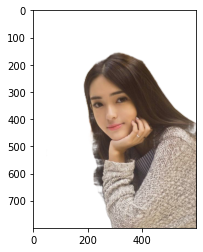

In [6]:
plt.imshow(plt.imread(df_data.iloc[0]["mask_id"]))

In [7]:
df_data_shuffled = df_data.sample(df_data.shape[0], random_state=42)
data_limit = df_data.shape[0]
df_data_shuffled = df_data_shuffled.iloc[:data_limit,:]

In [8]:
# test data is in the real world so imma skip that
train_size = df_data_shuffled.shape[0] - 500

train_data, val_data = df_data_shuffled.iloc[:train_size,:], df_data_shuffled.iloc[train_size:,:]

In [9]:
train_data.to_csv('train_data.csv', index=False)
val_data.to_csv('val_data.csv', index=False)

In [10]:
print("train_data.shape", train_data.shape)
print("val_data.shape", val_data.shape)

train_data.shape (24158, 2)
val_data.shape (500, 2)


## Define a generator, not that with this much data I'll need one, but to have

In [4]:
## sometimes it crops to only background which might not be a bad thing, not sure
def imageAugmet(path_img, path_mask):
    # read the image
    image = cv2.imread(path_img)

    # read the mask
    mask = cv2.imread(path_mask, cv2.IMREAD_UNCHANGED)
    w1, h1 = image.shape[:2]

    perspSize = random.randint(0,200)
    pts1 = np.float32([[0, 0], [0, w1],
                       [h1, 0], [h1, w1]])
    pts2 = np.float32([[random.randint(0,perspSize), random.randint(0,perspSize)], 
                       [random.randint(0,perspSize), random.randint(w1-perspSize,w1)],
                       [random.randint(h1-perspSize,h1), random.randint(0,perspSize)], 
                       [random.randint(h1-perspSize,h1), random.randint(w1-perspSize,w1)]])

    # Apply Perspective Transform
    perspMatrix = cv2.getPerspectiveTransform(pts1, pts2)
    image = cv2.warpPerspective(image, perspMatrix, (w1, h1))
    mask = cv2.warpPerspective(mask, perspMatrix, (w1, h1))


    center = (w1/2, h1/2)
    rotMatrix = cv2.getRotationMatrix2D(center, random.randint(-25,25), 1)
    
    image = cv2.warpAffine(image, rotMatrix, (w1, h1))
    mask = cv2.warpAffine(mask, rotMatrix, (w1, h1))

    wScale = w1//IMG_WIDTH
    hScale = h1//IMG_HEIGHT
    newScale = min(wScale,hScale)
    
    wOffset = (w1-(newScale*IMG_WIDTH))//2
    hOffset = (h1-(newScale*IMG_WIDTH))//2

    image = image[hOffset:h1-hOffset,wOffset:w1-wOffset,:]
    image = cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH))
    image = image[:,cropOffset:IMG_WIDTH-cropOffset,:]

    mask = mask[hOffset:h1-hOffset,wOffset:w1-wOffset,:]
    mask = cv2.resize(mask, (IMG_HEIGHT, IMG_WIDTH))
    mask = mask[:,cropOffset:IMG_WIDTH-cropOffset,:]
    
    return image, mask
    

In [5]:

def data_generator(batch_size=10, dataset="train_data.csv"):
    
    while True:
        
        # load the data in chunks (batches)
        for df in pd.read_csv(dataset, chunksize=batch_size):
            
            # get the list of images
            image_id_list = list(df['image_id'])
            # get a list of masks
            mask_id_list = list(df['mask_id'])
            
            # Create empty X matrix - 3 channels
            # Note: We use len(df) because the last batch will be smaller than the other batches.
            X_train = np.zeros((len(df), IMG_HEIGHT, CROP_WIDTH, 3), dtype=np.uint8)
            
            # create empty Y matrix - 1 channel
            Y_train = np.zeros((len(df), IMG_HEIGHT, CROP_WIDTH, 1), dtype=np.bool)

        
            
            # Create X_train, Y_train
            #================
            
            for i, (image_id, mask_id) in enumerate(zip(image_id_list,mask_id_list)):
                
                # select the folder_id from the list
#                 image_name = image_id.split('.')[0]

                # set the path to the image
                path_img = image_id
                
                # set the path to the mask
                path_mask = mask_id
                
                if not (os.path.exists(path_img) and os.path.exists(path_mask)):
                    continue


                ## I get the below error sooo try except it is
                ## error: OpenCV(4.5.5) /io/opencv/modules/imgproc/src/resize.cpp:4052: 
                ## error: (-215:Assertion failed) !ssize.empty() in function 'resize'
                try:
                    # augmet the image and mask with rotation, prespective and crop
                    image, mask = imageAugmet(path_img, path_mask)
                except:
                    continue
                
                # because I have three datasets and thay all have differant formating 
                # for the images I have to make sure they get converted accordingly
                channels = mask.shape[-1] if len(mask.shape) == 3 else 1
                mask = np.reshape(mask, (IMG_HEIGHT, CROP_WIDTH, channels))

                # select the alpha channel which is sometimes the only/first channel and sometimes the 4th
                mask = mask[:, :, 2:3] if len(mask.shape) == 3 and mask.shape[-1] == 4 else mask[:, :, 0:1]

                # insert the image into Y_train
                Y_train[i] = mask
                
                # insert the image into X_train
                X_train[i] = image


            yield X_train, Y_train


## Test the generator

In [6]:
train_gen = data_generator(batch_size=32, dataset="train_data.csv")
val_gen = data_generator(batch_size=32, dataset="val_data.csv")

x_train, y_train = next(train_gen)
x_val, y_val = next(val_gen)

print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("\n")
print("x_val: ", x_val.shape)
print("y_val: ", y_val.shape)

x_train:  (32, 176, 128, 3)
y_train:  (32, 176, 128, 1)


x_val:  (32, 176, 128, 3)
y_val:  (32, 176, 128, 1)


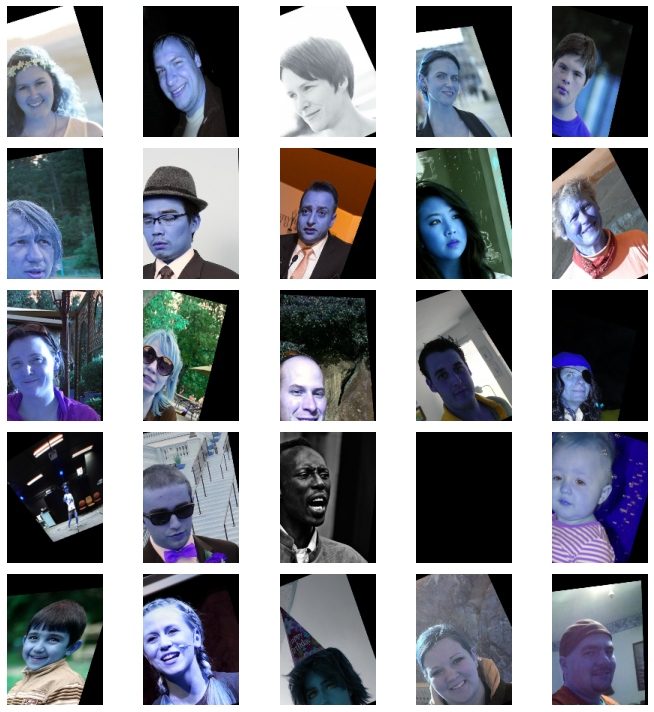

In [7]:
# Display the generator output - x_train

n = 5
fig, axs = plt.subplots(nrows=n, ncols=n, sharex=True, sharey=True, figsize=(10,10))
for i in range(n**2):
    ax = axs[i // n, i % n]
    ax.imshow(x_train[i,:,:,:], cmap=plt.cm.gray)
    ax.axis('off')

plt.tight_layout()
plt.show()

In [8]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, UpSampling2D
from tensorflow.keras.layers import Dropout, Lambda
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, DepthwiseConv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K

In [9]:

inputs = Input((IMG_HEIGHT, CROP_WIDTH,3), batch_size=1)

# normalize the images
s = Lambda(lambda x: x / 255) (inputs)


c1 = DepthwiseConv2D(kernel_size=(3, 3), strides=1, depth_multiplier=6, activation='elu',  data_format='channels_last',
                     kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = DepthwiseConv2D(kernel_size=(3, 3), strides=1, depth_multiplier=1, activation='elu', 
                     kernel_initializer='he_normal', padding='same', name="c1") (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = DepthwiseConv2D(kernel_size=(3, 3), strides=1, depth_multiplier=2, activation='elu', 
                     kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = DepthwiseConv2D(kernel_size=(3, 3), strides=1, depth_multiplier=1, activation='elu', 
                     kernel_initializer='he_normal', padding='same', name="c2") (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = DepthwiseConv2D(kernel_size=(3, 3), strides=1, depth_multiplier=2, activation='elu', 
                     kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = DepthwiseConv2D(kernel_size=(3, 3), strides=1, depth_multiplier=1, activation='elu', 
                     kernel_initializer='he_normal', padding='same', name="c3") (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = DepthwiseConv2D(kernel_size=(3, 3), strides=1, depth_multiplier=2, activation='elu', 
                     kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = DepthwiseConv2D(kernel_size=(3, 3), strides=1, depth_multiplier=1, activation='elu', 
                     kernel_initializer='he_normal', padding='same', name="c4") (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = DepthwiseConv2D(kernel_size=(3, 3), strides=1, depth_multiplier=2, activation='elu', 
                     kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = DepthwiseConv2D(kernel_size=(3, 3), strides=1, depth_multiplier=1, activation='elu', 
                     kernel_initializer='he_normal', padding='same', name="c5") (c5)

u6 = Conv2DTranspose(144, (2, 2), strides=(2, 2), padding='same', name="u6") (c5)
u6 = concatenate([u6, c4])
c6 = DepthwiseConv2D(kernel_size=(3, 3), strides=1, depth_multiplier=1, activation='elu', 
                     kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = DepthwiseConv2D(kernel_size=(3, 3), strides=1, depth_multiplier=1, activation='elu', 
                     kernel_initializer='he_normal', padding='same', name="c6") (c6)

u7 = Conv2DTranspose(72, (2, 2), strides=(2, 2), padding='same', name="u7") (c6)
u7 = concatenate([u7, c3])
c7 = DepthwiseConv2D(kernel_size=(3, 3), strides=1, depth_multiplier=1, activation='elu', 
                     kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = DepthwiseConv2D(kernel_size=(3, 3), strides=1, depth_multiplier=1, activation='elu', 
                     kernel_initializer='he_normal', padding='same', name="c7") (c7)

u8 = Conv2DTranspose(36, (2, 2), strides=(2, 2), padding='same', name="u8") (c7)
u8 = concatenate([u8, c2])
c8 = DepthwiseConv2D(kernel_size=(3, 3), strides=1, depth_multiplier=1, activation='elu', 
                     kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = DepthwiseConv2D(kernel_size=(3, 3), strides=1, depth_multiplier=1, activation='elu', 
                     kernel_initializer='he_normal', padding='same', name="c8") (c8)

u9 = Conv2DTranspose(18, (2, 2), strides=(2, 2), padding='same', name="u9") (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = DepthwiseConv2D(kernel_size=(3, 3), strides=1, depth_multiplier=1, activation='elu', 
                     kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = DepthwiseConv2D(kernel_size=(3, 3), strides=1, depth_multiplier=1, activation='elu', 
                     kernel_initializer='he_normal', padding='same', name="c9") (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)#

model = Model(inputs=[inputs], outputs=[outputs])

model.compile(optimizer='adam', loss='binary_crossentropy',metrics="acc")

## to concat the training data when doing multiple runs
first_run = True

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(1, 176, 128, 3)]   0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (1, 176, 128, 3)     0           input_1[0][0]                    
__________________________________________________________________________________________________
depthwise_conv2d (DepthwiseConv (1, 176, 128, 18)    180         lambda[0][0]                     
__________________________________________________________________________________________________
dropout (Dropout)               (1, 176, 128, 18)    0           depthwise_conv2d[0][0]           
______________________________________________________________________________________________

2022-01-31 15:24:13.689567: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-31 15:24:13.689885: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-31 15:24:13.690137: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-31 15:24:13.691452: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-31 15:24:13.691715: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [12]:
## batch size of 1, because TFlite considers it as a satic model/ graph
## and that enables speedups when running the model on a phone
## Maybe there is another way??
BATCH_SIZE = 1
num_train_samples = 14158#
num_val_samples = 500
train_batch_size = BATCH_SIZE
val_batch_size = BATCH_SIZE

# determine numtrain steps
train_steps = np.ceil(num_train_samples / train_batch_size)-2
# determine num val steps
val_steps = np.ceil(num_val_samples / val_batch_size)-2

In [13]:
train_gen = data_generator(batch_size=BATCH_SIZE, 
                           dataset="train_data.csv")
val_gen = data_generator(batch_size=BATCH_SIZE, 
                         dataset="val_data.csv")

In [22]:
history = model.fit(train_gen, steps_per_epoch=train_steps, 
          validation_data=val_gen, validation_steps=val_steps, 
          epochs=5)

Epoch 1/5
14156/14156 [==============================] - 265s 19ms/step - loss: 0.0619 - acc: 0.9766 - val_loss: 0.0586 - val_acc: 0.9775
Epoch 2/5
14156/14156 [==============================] - 259s 18ms/step - loss: 0.0620 - acc: 0.9766 - val_loss: 0.0554 - val_acc: 0.9790
Epoch 3/5
14156/14156 [==============================] - 266s 19ms/step - loss: 0.0623 - acc: 0.9767 - val_loss: 0.0525 - val_acc: 0.9800
Epoch 4/5
14156/14156 [==============================] - 267s 19ms/step - loss: 0.0613 - acc: 0.9768 - val_loss: 0.0542 - val_acc: 0.9791
Epoch 5/5
14156/14156 [==============================] - 270s 19ms/step - loss: 0.0634 - acc: 0.9764 - val_loss: 0.0606 - val_acc: 0.9774


## Combine histories as i tend to run more than one training run

In [19]:
if first_run:
    big_history = {"loss": [], "acc": [], "val_loss": [], "val_acc": []}
    first_run = False

In [23]:
big_history["loss"] = big_history["loss"] + history.history["loss"]
big_history["acc"] = big_history["acc"] + history.history["acc"]

big_history["val_loss"] = big_history["val_loss"] + history.history["val_loss"]
big_history["val_acc"] = big_history["val_acc"] + history.history["val_acc"]

In [29]:
model.save("BackgroundRemoverOvertrained.h5", save_format="h5")

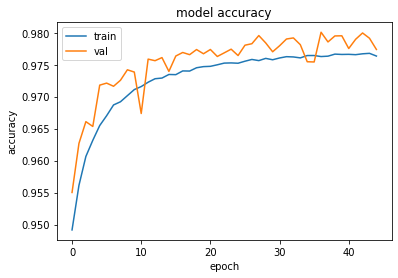

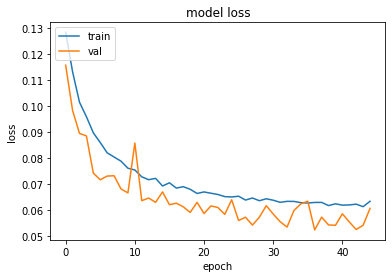

In [24]:
# summarize history for accuracy
plt.plot(big_history['acc'])
plt.plot(big_history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(big_history['loss'])
plt.plot(big_history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

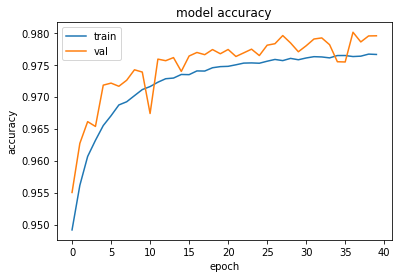

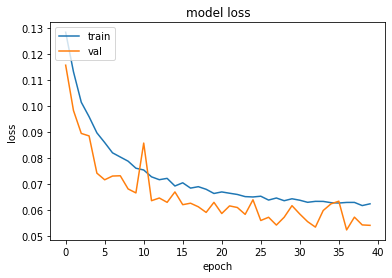

In [17]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [25]:
# Converting a tf.Keras model to a TensorFlow Lite model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)

converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_quant_model = converter.convert()

# Save the TF Lite model.
with tf.io.gfile.GFile('BackgroundRemoverStatic2WxH_128x176.tflite', 'wb') as f:
    f.write(tflite_quant_model)

2022-01-31 19:08:14.725869: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /tmp/tmpq58hs52h/assets


2022-01-31 19:08:16.463794: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-31 19:08:16.463971: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2022-01-31 19:08:16.464016: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2022-01-31 19:08:16.464160: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-31 19:08:16.464335: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-31 19:08:16.464494: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] su

In [ ]:
# model = keras.models.load_model('path/to/location')

In [114]:
# Save the TF Lite model.
with tf.io.gfile.GFile('BackgroundRemoverStatic128x128.tflite', 'wb') as f:
    f.write(tflite_quant_model)